In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

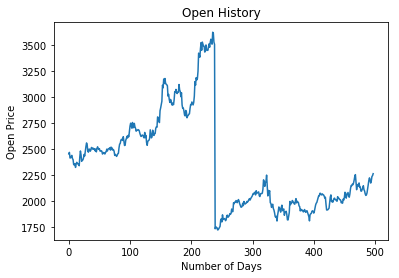

In [2]:
data = pd.read_csv("14-06-2017-TO-13-06-2019TCSALLN.csv")
y = np.array(data["Open Price"])
y = y[1:]
X = np.array(data[["Prev Close","High Price","Low Price","Last Price","Close Price","Total Traded Quantity","Turnover","No. of Trades","Deliverable Qty","% Dly Qt to Traded Qty","Average Price"]])
X = X[:X.shape[0]-1]
plt.figure()
plt.plot(data["Open Price"])
plt.title("Open History")
plt.xlabel("Number of Days")
plt.ylabel("Open Price")
plt.show()

In [3]:
def normalizeX(X):
    X = (X - np.min(X,axis = 0,keepdims = True))/(np.max(X,axis = 0,keepdims = True) - np.min(X,axis = 0,keepdims = True))
    return X
def normalizeY(Y_train,Y_test):
    Y_train = (Y_train - np.min(Y_train))/(np.max(Y_train) - np.min(Y_train))
    Y_test = (Y_test - np.min(Y_train))/(np.max(Y_train) - np.min(Y_train))
    return (Y_train, Y_test)
X = normalizeX(X)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size = 0.2,shuffle = False)
Y_train, Y_test = normalizeY(Y_train,Y_test)
print(X_train.shape)
print(X_train[:2,:])
print(Y_train.shape)
print(X_test.shape)
print(X_test[:2,:])
print(Y_test.shape)

(397, 11)
[[0.38783805 0.38203    0.39961857 0.39327241 0.3977472  0.01593902
  0.0136246  0.08906136 0.01446578 0.6131     0.3898577 ]
 [0.3977472  0.37878241 0.37275706 0.36392531 0.36639923 0.03307985
  0.02782757 0.1349947  0.03614865 0.7612     0.36811447]]
(397,)
(100, 11)
[[0.0951331  0.10160318 0.0990115  0.09561647 0.09941023 0.05379366
  0.03555564 0.24792813 0.03346173 0.4382     0.09983956]
 [0.09941023 0.09451518 0.09608359 0.0920143  0.09579725 0.05486867
  0.03601271 0.38578408 0.04953804 0.6362     0.09286621]]
(100,)


In [5]:
X_train=X_train.T
X_test=X_test.T
print(X_train.shape)
print(X_test.shape)

(11, 397)
(11, 100)


In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [7]:
def initialize_parameters(input_dims,no_of_hidden_units):
    parameters = {}
    parameters["W_forget"] = np.random.randn(no_of_hidden_units,no_of_hidden_units + input_dims)*np.sqrt(2/(no_of_hidden_units + input_dims))
    parameters["W_input"] = np.random.randn(no_of_hidden_units,no_of_hidden_units + input_dims)*np.sqrt(2/(no_of_hidden_units + input_dims))
    parameters["W_output"] = np.random.randn(no_of_hidden_units,no_of_hidden_units + input_dims)*np.sqrt(2/(no_of_hidden_units + input_dims))
    parameters["W_c"] = np.random.randn(no_of_hidden_units,no_of_hidden_units + input_dims)*np.sqrt(2/(no_of_hidden_units + input_dims))
    parameters["W_y"] = np.random.randn(1,no_of_hidden_units)*np.sqrt(2/(no_of_hidden_units))
    parameters["b_forget"] = np.zeros((no_of_hidden_units,1))
    parameters["b_input"] = np.zeros((no_of_hidden_units,1))
    parameters["b_output"] = np.zeros((no_of_hidden_units,1))
    parameters["b_c"] = np.zeros((no_of_hidden_units,1))
    parameters["b_y"] = np.zeros((1,1))
    return parameters

In [8]:
def lstm_forward_prop(X_train,Y_train,parameters,no_of_hidden_units):
    cache = {}
    T_x = X_train.shape[1]
    c_t = np.zeros((no_of_hidden_units,1))
    h_t = np.zeros((no_of_hidden_units,1))
    cost = 0
    y_pred = []
    for i in range(T_x):
        h_X = np.concatenate((h_t,np.array(X_train[:,i]).reshape(X_train.shape[0],1)),axis=0)
        f_t = sigmoid(np.dot(parameters["W_forget"],h_X) + parameters["b_forget"])
        i_t = sigmoid(np.dot(parameters["W_input"],h_X) + parameters["b_input"])
        c_tilde_t = np.tanh(np.dot(parameters["W_c"],h_X) + parameters["b_c"])
        c_t = f_t*c_t + i_t*c_tilde_t
        o_t = sigmoid(np.dot(parameters["W_output"],h_X) + parameters["b_output"])
        h_t = o_t*np.tanh(c_t)
        y_hat = np.dot(parameters["W_y"],h_t) + parameters["b_y"]
        y_pred.append(y_hat[0]) 
        cost += (1/2)*np.square(Y_train[i] - y_hat)
        cache["timestep"+str(i+1)] = [f_t,i_t,c_tilde_t,c_t,o_t,h_t,y_hat,h_X]
    return (cost,cache,y_pred)     

In [9]:
def lstm_back_prop(cache,parameters,t_x,Y_train,no_of_hidden_units,input_dims):
    gradient = {}
    gradient["dW_forget"] = np.zeros((no_of_hidden_units,no_of_hidden_units + input_dims))
    gradient["dW_input"] = np.zeros((no_of_hidden_units,no_of_hidden_units + input_dims))
    gradient["dW_output"] = np.zeros((no_of_hidden_units,no_of_hidden_units + input_dims))
    gradient["dW_c"] = np.zeros((no_of_hidden_units,no_of_hidden_units + input_dims))
    gradient["dW_y"] = np.zeros((1,no_of_hidden_units))
    gradient["db_forget"] = np.zeros((no_of_hidden_units,1))
    gradient["db_input"] = np.zeros((no_of_hidden_units,1))
    gradient["db_output"] = np.zeros((no_of_hidden_units,1))
    gradient["db_c"] = np.zeros((no_of_hidden_units,1))
    gradient["db_y"] = np.zeros((1,1))
    (dh_t,dc_t) = (np.zeros((no_of_hidden_units,1)),np.zeros((no_of_hidden_units,1)))
    for i in range(t_x,0,-1):
        dy_hat = cache["timestep"+str(i)][6] - Y_train[i-1]
        dh_t = dy_hat*parameters["W_y"].T + dh_t
        do_t = dh_t*np.tanh(cache["timestep"+str(i)][3])*cache["timestep"+str(i)][4]*(1 - cache["timestep"+str(i)][4])
        dc_t = dh_t*cache["timestep"+str(i)][4]*(1 - np.square(np.tanh(cache["timestep"+str(i)][3]))) + dc_t
        dc_tilde_t = dc_t*cache["timestep"+str(i)][1]*(1 - np.square(cache["timestep"+str(i)][2]))
        di_t = dc_t*cache["timestep"+str(i)][2]*cache["timestep"+str(i)][1]*(1 - cache["timestep"+str(i)][1])
        if i == 1:
            df_t = dc_t*np.zeros(df_t.shape)
        else:
            df_t = dc_t*cache["timestep"+str(i - 1)][3]*cache["timestep"+str(i)][0]*(1 - cache["timestep"+str(i)][0])
        gradient["db_y"] += dy_hat
        gradient["db_forget"] += df_t
        gradient["db_input"] += di_t
        gradient["db_c"] += dc_tilde_t
        gradient["db_output"] += do_t
        gradient["dW_y"] += np.dot(dy_hat,cache["timestep"+str(i)][5].T)
        gradient["dW_forget"] += np.dot(df_t,cache["timestep"+str(i)][7].T)
        gradient["dW_input"] += np.dot(di_t,cache["timestep"+str(i)][7].T)
        gradient["dW_c"] += np.dot(dc_tilde_t,cache["timestep"+str(i)][7].T)
        gradient["dW_output"] += np.dot(do_t,cache["timestep"+str(i)][7].T)
        dh_X = np.zeros((no_of_hidden_units+input_dims,1))
        dh_X += np.dot(parameters["W_forget"].T,df_t)
        dh_X += np.dot(parameters["W_input"].T,di_t)
        dh_X += np.dot(parameters["W_output"].T,do_t)
        dh_X += np.dot(parameters["W_c"].T,dc_tilde_t)
        dh_t = dh_X[:no_of_hidden_units,:]
        dc_t =  dc_t*cache["timestep"+str(i)][0]
    return gradient

In [10]:
def update_parameters(parameters,gradient,learning_rate):
    for key in gradient.keys():
        parameters[key[1:]] -= learning_rate*gradient[key]
    return parameters

In [11]:
#def adam_optimizer(parameters,gradient,learning_rate,beta_1,beta_2):
#    """
#    beta_1 : Momentum parameter
#    beta_2 : RMS prop parameter
    
#    """
#    for key in gradient.keys():
        

In [12]:
def train_model(X_train,Y_train,learning_rate,no_of_hidden_units,epochs = 50):
    input_dims = X_train.shape[0]
    t_x = X_train.shape[1]
    parameters = initialize_parameters(input_dims,no_of_hidden_units)
    costs = []
    for i in range(epochs):
        cost,cache,Y_pred = lstm_forward_prop(X_train,Y_train,parameters,no_of_hidden_units)
        gradient = lstm_back_prop(cache,parameters,t_x,Y_train,no_of_hidden_units,input_dims)
        parameters = update_parameters(parameters,gradient,learning_rate)
        cost = np.squeeze(cost)
        costs.append(cost)
        if i%100 == 0:
            print("Cost after "+ str(i)+" number of iterations: ",cost)
    return (parameters,costs)

In [19]:
print(X_train.shape)
print(Y_train.shape)
parameters,costs = train_model(X_train,Y_train,0.002,15,1000)

(11, 397)
(397,)
Cost after 0 number of iterations:  19.464392897773816
Cost after 100 number of iterations:  0.781986847241876
Cost after 200 number of iterations:  0.6573983418815683
Cost after 300 number of iterations:  0.5902107053981932
Cost after 400 number of iterations:  0.5483985051680085
Cost after 500 number of iterations:  0.5204897412843247
Cost after 600 number of iterations:  0.5011320260269455
Cost after 700 number of iterations:  0.4873792444776106
Cost after 800 number of iterations:  0.477433003757832
Cost after 900 number of iterations:  0.47012639343927215


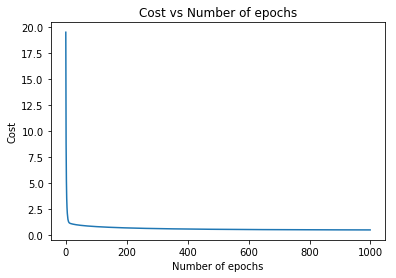

In [20]:
plt.figure()
plt.plot(costs)
plt.xlabel("Number of epochs")
plt.ylabel("Cost")
plt.title("Cost vs Number of epochs")
plt.show()

In [23]:
def predict(parameters,X,Y_train,Y_test):
    Y = np.concatenate((Y_train,Y_test))
    X = X.T
    cost,cache,Y_pred = lstm_forward_prop(X,Y,parameters,15) 
    return Y_pred
Y_pred = predict(parameters,X,Y_train,Y_test)

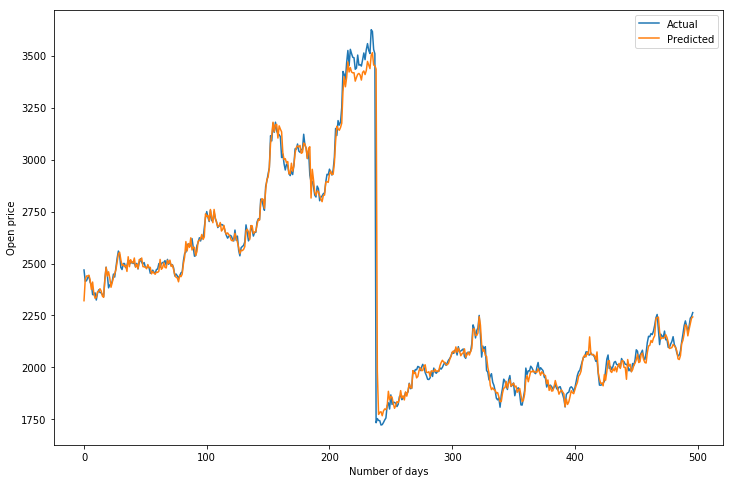

In [24]:
Y_pred = np.array(Y_pred)*(np.max(y[:397]) - np.min(y[:397]))
Y_pred += np.min(y[:397])
plt.figure(figsize = (12,8))
plt.plot(y,label = "Actual")
plt.plot(Y_pred,label = "Predicted")
plt.xlabel("Number of days")
plt.ylabel("Open price")
plt.legend(loc = "best")
plt.show()

In [25]:
def gradient_check(X_train,Y_train,no_of_hidden_units):
    #np.random.seed(1)
    params = initialize_parameters(X_train.shape[0],no_of_hidden_units)
    grad_approx = {}
    epsilon = 1e-7
    for key in params.keys():
        grad_approx[key] = np.zeros(params[key].shape)
        for i in range(params[key].shape[0]):
            for j in range(params[key].shape[1]):
                params[key][i][j] += epsilon
                cost1,cache,Y_pred = lstm_forward_prop(X_train,Y_train,params,no_of_hidden_units)
                params[key][i][j] -= 2*epsilon
                cost2,cache,Y_pred = lstm_forward_prop(X_train,Y_train,params,no_of_hidden_units)
                grad_approx[key][i][j] = (cost1 - cost2)/(2*epsilon)
                params[key][i][j] += epsilon
    cost,cache,Y_pred = lstm_forward_prop(X_train,Y_train,params,no_of_hidden_units)
    grad = lstm_back_prop(cache,params,X_train.shape[1],Y_train,no_of_hidden_units,X_train.shape[0])
    grad_vec = np.zeros(1)
    grad_apx_vec = np.zeros(1)
    for key in grad.keys():
        grad_vec = np.concatenate((grad_vec,grad[key].reshape(grad[key].shape[0]*grad[key].shape[1])))
#        print(key + str(":"),grad[key])
        grad_apx_vec = np.concatenate((grad_apx_vec,grad_approx[key[1:]].reshape(grad_approx[key[1:]].shape[0]*grad_approx[key[1:]].shape[1])))
#        print(key + str(":"),grad_approx[key[1:]])
    grad_vec = grad_vec[1:]
    grad_apx_vec = grad_apx_vec[1:]
    numerator = np.linalg.norm(grad_vec - grad_apx_vec)
    denominator = (np.linalg.norm(grad_vec) + np.linalg.norm(grad_apx_vec))
    dist = numerator/denominator
    if dist <= epsilon:
        print("Gradient seems right")
    else:
        print("oops!!! Gradient seems wrong")
    return dist

In [28]:
distance = gradient_check(X_train,Y_train,15)

dW_forget: [[ 1.05818968e-02  3.12170169e-02 -3.36439023e-02 -9.09424460e-03
  -3.34956308e-02 -1.98071758e-02 -9.73432322e-04  5.62111054e-03
  -1.45868005e-03  3.10725397e-02 -1.09309094e-02  7.78657224e-03
   7.72929072e-03 -2.15108196e-02 -8.46443214e-03 -4.64703791e-02
  -4.56710406e-02 -4.65198760e-02 -4.61438993e-02 -4.62380378e-02
   7.39460336e-03  3.33731134e-03  3.24488324e-02  5.72937175e-03
   4.40719857e-02 -4.60638297e-02]
 [-4.60946516e-02 -3.02357109e-01  2.56597086e-01  1.89687308e-01
   5.16447228e-01 -2.07896325e-02  3.55685610e-02  2.64568649e-01
   3.48327404e-01 -3.62423910e-02  2.75321933e-01 -1.95258584e-01
   3.27246683e-02  1.77425667e-01 -8.05458645e-02  1.23355796e+00
   1.21369000e+00  1.22483550e+00  1.22456836e+00  1.23007240e+00
   3.84820340e-02  5.72795102e-02  1.41608309e-01  3.16536736e-02
   6.78306571e-01  1.21418564e+00]
 [ 9.22145910e-02  6.66672341e-01 -6.06520269e-01 -2.90335845e-01
  -1.18274437e+00 -1.06829310e-01 -8.11591631e-02 -4.56256094

In [29]:
print(distance)

1.585738691233061e-08
